In [1]:
import os
import sys
import random
from ultralytics import YOLO
from IPython.display import Image

# Add the 'src' directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Now we can import your config file
from config import Config

In [10]:
# --- 1. Define Model Path (robust) ---
model_name = 'best.pt'
candidate_paths = [
    os.path.join('..', 'models', 'weights', model_name),                       # ../models/weights/best.pt
    os.path.join('..', Config.MODEL_PHASE2_WEIGHTS),                           # runs/detect/yolov8_phase2_fine/weights/best.pt
    Config.MODEL_PHASE2_WEIGHTS,                                               # relative runs/... (may fail depending on CWD)
    # Ensure REPO_ROOT is defined if you use this line in config.py
    # str(Config.REPO_ROOT / 'models' / 'weights' / model_name)                  # absolute path variant
]

# Find the first existing model path
model_path = next((p for p in candidate_paths if p and os.path.exists(p)), None)

print("Checked model paths:")
for p in candidate_paths:
    # Check existence relative to notebook or use absolute paths if defined
    check_path = p if os.path.isabs(p) else os.path.join(os.path.dirname(os.getcwd()), p)
    print("  ", p, "->", "OK" if os.path.exists(check_path) else "MISSING")


if not model_path:
    # If using relative path for Config.MODEL_PHASE2_WEIGHTS, adjust the error message or logic
    model_path_from_config = os.path.join('..', Config.MODEL_PHASE2_WEIGHTS)
    if os.path.exists(model_path_from_config):
        model_path = model_path_from_config
    else:
        raise FileNotFoundError(f"Model file not found. Checked: {candidate_paths}. Place 'best.pt' in '../models/weights/' or ensure '{model_path_from_config}' exists.")

print("Using model:", model_path)


# --- 2. Define Test Image Path ---

# --- Option A: Test using a random image from the dataset (Commented out) ---
# images_dir = Config.IMAGES_DIR
# if not os.path.isdir(images_dir):
#     raise FileNotFoundError(f"Images dir not found: {images_dir}")
# test_image_name = random.choice(os.listdir(images_dir))
# image_path = os.path.join(images_dir, test_image_name)
# print("Using image:", image_path)

# --- Option B: Test using your specific image ---
test_image_name = 'test/image_Jacket.png'
# Assuming test_salma.jpeg is in the same 'notebooks' folder as this notebook
image_path = os.path.abspath(test_image_name) # Use absolute path
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Your image not found at {image_path}. Make sure '{test_image_name}' is in the 'notebooks' folder.")
print("Using image:", image_path)

Checked model paths:
   ../models/weights/best.pt -> MISSING
   ../runs/detect/yolov8_phase2_fine/weights/best.pt -> MISSING
   runs/detect/yolov8_phase2_fine/weights/best.pt -> OK
Using model: ../models/weights/best.pt
Using image: /Users/macm4/repositories/Machine Learning Model/modisch-model/notebooks/test/image_Jacket.png


In [11]:

# --- 3. Load model and run prediction with debug info ---
model = YOLO(model_path)

# Lower max_det and explicit conf to avoid NMS/timeouts dropping detections
results = model.predict(source=image_path, conf=0.2, iou=0.45, max_det=200, save=True)

res = results[0]
n_boxes = len(res.boxes)
print(f"Detections: {n_boxes}")
if n_boxes == 0:
    print("No boxes detected — try lowering conf or checking model weights.")
else:
    # print box coords, conf, class id/name
    for i, box in enumerate(res.boxes):
        xyxy = box.xyxy[0].cpu().numpy()
        conf = float(box.conf[0].cpu().numpy()) if hasattr(box, 'conf') else None
        cls_id = int(box.cls[0].cpu().numpy()) if hasattr(box, 'cls') else None
        cls_name = model.names[cls_id] if cls_id is not None and cls_id in model.names else str(cls_id)
        print(f" {i}: bbox={xyxy.tolist()}, conf={conf:.3f}, class={cls_id} ({cls_name})")

# Show annotated image produced by YOLO
annotated_dir = res.save_dir  # directory where YOLO saved annotated image
annotated_path = os.path.join(annotated_dir, test_image_name)
print("Annotated image saved to:", annotated_path)

from IPython.display import Image, display
display(Image(filename=annotated_path))


image 1/1 /Users/macm4/repositories/Machine Learning Model/modisch-model/notebooks/test/image_Jacket.png: 512x512 (no detections), 23.7ms
Speed: 1.4ms preprocess, 23.7ms inference, 0.2ms postprocess per image at shape (1, 3, 512, 512)
Results saved to /Users/macm4/repositories/Machine Learning Model/modisch-model/runs/detect/predict5
Detections: 0
No boxes detected — try lowering conf or checking model weights.
Annotated image saved to: /Users/macm4/repositories/Machine Learning Model/modisch-model/runs/detect/predict5/test/image_Jacket.png


FileNotFoundError: [Errno 2] No such file or directory: '/Users/macm4/repositories/Machine Learning Model/modisch-model/runs/detect/predict5/test/image_Jacket.png'

Visualizing results from: ../runs/detect/yolov8_phase2_fine


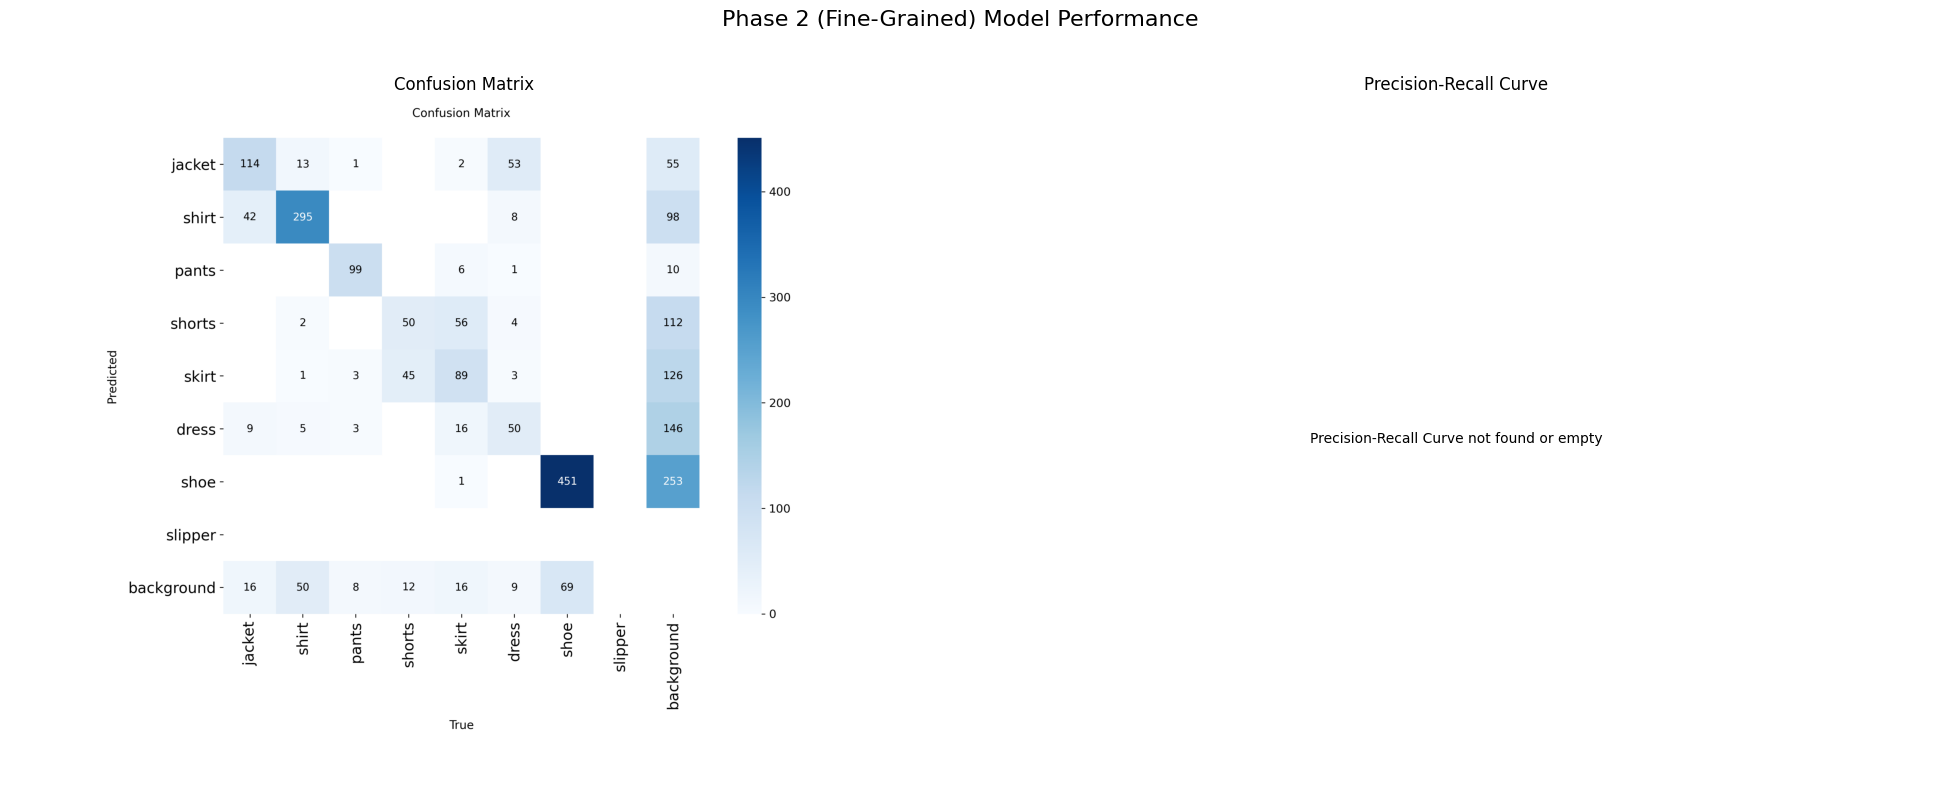

In [1]:
import os
from glob import glob

import cv2
import matplotlib.pyplot as plt

# --- 📊 Visualize Phase 2 Results (robust) ---
run_matches = sorted(glob(os.path.join('..', 'runs', 'detect', 'yolov8_phase2_fine*')))
if not run_matches:
    print("⚠️ No Phase 2 runs found in ../runs/detect/. Skipping visualization.")
else:
    phase2_run_dir = run_matches[-1]
    print(f"Visualizing results from: {phase2_run_dir}")

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle('Phase 2 (Fine-Grained) Model Performance', fontsize=16)

    def safe_show(ax, img_filename, title):
        img_path = os.path.join(phase2_run_dir, img_filename)
        loaded = False
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                try:
                    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                    loaded = True
                except cv2.error:
                    loaded = False

        if not loaded:
            ax.text(0.5, 0.5, f'{title} not found or empty', ha='center', va='center')

        ax.set_title(title)
        ax.axis('off')

    safe_show(axes[0], 'confusion_matrix.png', 'Confusion Matrix')
    safe_show(axes[1], 'PR_curve.png', 'Precision-Recall Curve')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()